In [1]:
import csv
import random
import re
import unittest
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from skimage.measure import EllipseModel

In [2]:
def floodfill(image: np.ndarray, y: int, x: int, processed: set) -> list:
    pixels_to_process = [(y, x)]
    particle = set()
    while pixels_to_process:
        y, x = pixels_to_process.pop(0)
        if (y, x) not in particle and image[y, x]:
            particle.add((y, x))
            if y - 1 >= 0:
                pixels_to_process.append((y - 1, x))
            if y + 1 < image.shape[0]:
                pixels_to_process.append((y + 1, x))
            if x - 1 >= 0:
                pixels_to_process.append((y, x - 1))
            if x + 1 < image.shape[1]:
                pixels_to_process.append((y, x + 1))
    processed.update(particle)
    return list(particle)


def extract_particles(image: np.ndarray) -> list:
    particles = []
    processed = set()
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if (y, x) not in processed and image[y, x]:
                particles.append(floodfill(image, y, x, processed))
    return particles


def extract_contours(particles: list) -> list:
    contours_ = []
    for particle in particles:
        im = np.zeros((1024, 1024), dtype=np.uint8)
        for y, x in particle:
            im[y, x] = 255
        contours, _ = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_.append(contours[0].squeeze())

    return contours_


def compute_particle_areas(particles: list) -> list:
    areas = []
    for particle in particles:
        areas.append(len(particle))
    return areas


def euclidean_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return np.sqrt(np.sum(np.power(p2 - p1, 2)))


def compute_contour_lengths(contours: list) -> list:
    lengths = []
    for contour in contours:
        length = 0
        for index in range(contour.shape[0] - 1):
            length += euclidean_distance(contour[index], contour[index + 1])
        length += euclidean_distance(contour[-1], contour[0])
        lengths.append(length)
    return lengths


def compute_porosities(particle_areas: list, contours: list) -> list:
    porosities = []
    for area, contour in zip(particle_areas, contours):
        hull = ConvexHull(contour)
        porosities.append(area / hull.volume)
    return porosities


def compute_ellipse_params(particles: list) -> list:
    params = []
    for particle in particles:
        ellipse = EllipseModel()
        ellipse.estimate(np.array(particle))
        params.append(ellipse.params)
    return params

In [3]:
class Tests(unittest.TestCase):
    def test_floodfill(self):
        image = np.array([[0, 0, 255, 255], 
                          [0, 0, 255, 255],
                          [255, 255, 0, 0],
                          [255, 255, 0, 0]])
        particles = extract_particles(image)
        particles = [sorted(particle) for particle in particles]
        particles_gt = [[(0, 2), (0, 3), (1, 2), (1, 3)], [(2, 0), (2, 1), (3, 0), (3, 1)]]
        self.assertListEqual(particles, particles_gt)

unittest.main(argv=[""], verbosity=2, exit=False)

test_floodfill (__main__.Tests.test_floodfill) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


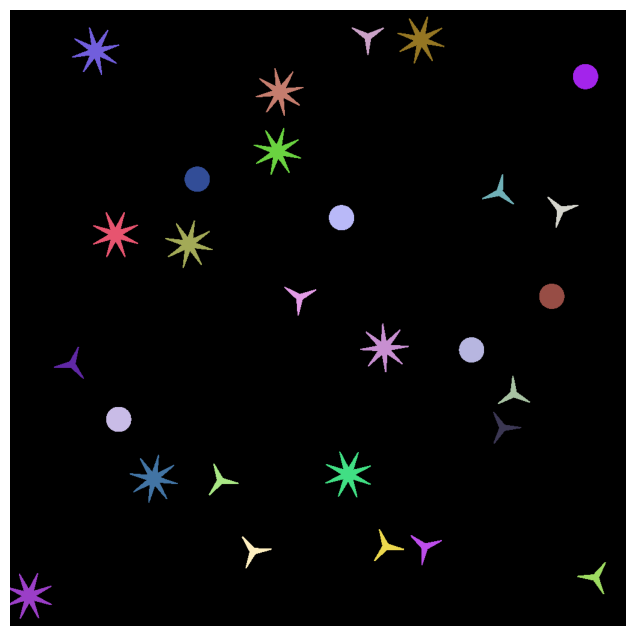

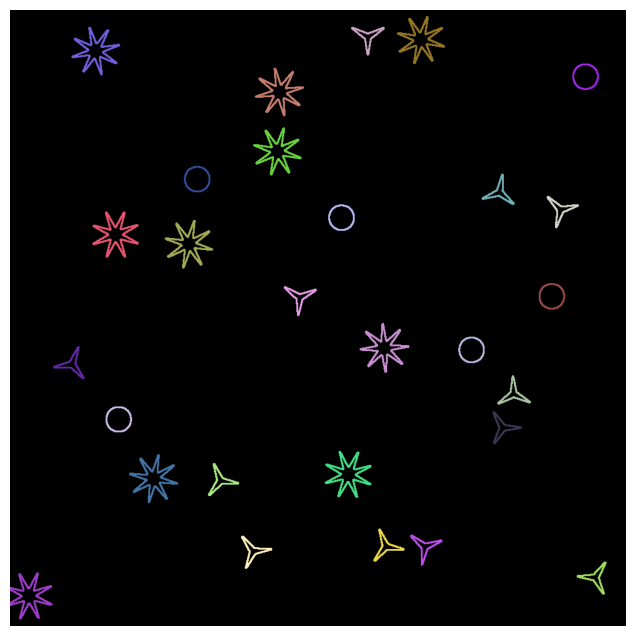

In [4]:
image = cv2.imread("shapes_binary.png", cv2.IMREAD_GRAYSCALE)
particles = extract_particles(image)
contours = extract_contours(particles)

colors = []
im = np.zeros((1024, 1024, 3), np.uint8)
for particle in particles:
    b, g, r = random.randint(30, 255), random.randint(30, 255), random.randint(30, 255)
    colors.append((b, g, r))
    for y, x in particle:
        im[y, x] = (b, g, r)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(im, cmap="gray")
plt.show()

im = np.zeros((1024, 1024, 3), np.uint8)
for i, c in enumerate(contours):
    b, g, r = random.randint(30, 255), random.randint(30, 255), random.randint(30, 255)
    im = cv2.drawContours(im, [c], 0, colors[i], 2)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(im, cmap="gray")
plt.show()

In [5]:
particle_areas = compute_particle_areas(particles)
contour_lengths = compute_contour_lengths(contours)
porosities = compute_porosities(particle_areas, contours)
ellipse_params = compute_ellipse_params(particles)

X_shapes_binary = []
for i in range(len(particle_areas)):
    X_shapes_binary.append((particle_areas[i], contour_lengths[i], porosities[i], *ellipse_params[i]))

In [6]:
training_dir = Path("./training_data")
X = []
y = []
for image_path in sorted(training_dir.glob("*.png")):
    m = re.match(r".*image_([0-9]+).png", str(image_path))
    csv_path = training_dir / f"shapes_{m.group(1)}.csv"

    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    particles = extract_particles(image)
    contours = extract_contours(particles)
    particle_areas = compute_particle_areas(particles)
    contour_lengths = compute_contour_lengths(contours)
    porosities = compute_porosities(particle_areas, contours)
    ellipse_params = compute_ellipse_params(particles)

    with open(csv_path, "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=";")
        for row in reader:
            pixel, label = (int(row[1]), int(row[0])), row[2]
            for i, particle in enumerate(particles):
                if pixel in particle:
                    X.append((particle_areas[i], contour_lengths[i], porosities[i], *ellipse_params[i]))
                    y.append(label)


/home/matthias/Documents/advanced_computer_vision_ss2024_Pijarowski_Matthias/venv/lib/python3.12/site-packages/skimage/measure/fit.py:522: RuntimeWarning: invalid value encountered in scalar divide
  phi = 0.5 * np.arctan((2.0 * b) / (a - c))


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
tree = DecisionTreeClassifier().fit(X_train, y_train)
tree.score(X_test, y_test)

0.9824561403508771

In [10]:
tree_pred = tree.predict(X_shapes_binary).tolist()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [12]:
class TDataset(Dataset):
    MAPPING = {
            "8-tipped-star": 0,
            "3-tipped-star": 1,
            "circle": 2
        }
    
    MAPPING_REV = {
            0: "8-tipped-star",
            1: "3-tipped-star",
            2: "circle"
        }

    def __init__(self, X, y) -> None:
        self.X = torch.tensor(X, dtype=torch.float)
        self.X = (self.X - self.X.mean(dim=0)) / self.X.std(dim=0)
        self.y = torch.tensor(self.y_to_numeric(y), dtype=torch.long)

    def y_to_numeric(self, y):
        y_new = []
        for elem in y:
            y_new.append(TDataset.MAPPING[elem])
        return y_new


    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

training_data = TDataset(X_train, y_train)
test_data = TDataset(X_test, y_test)

train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [13]:
model = nn.Sequential(
    nn.Linear(8, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, 3)
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=3, bias=True)
)


In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            print(f"Train loss: {loss.item()}")

def test_loop(dataloder, model, loss_fn):
    model.eval()

    size = len(dataloder.dataset)
    num_batches = len(dataloder)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloder:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Acc: {correct}, Test Loss: {test_loss}")

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 50
for t in range(epochs):
    print(f"Epoch {t} \n")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 0 

Train loss: 1.081577181816101
Train loss: 1.1289249658584595
Train loss: 0.9202893972396851
Train loss: 0.8960201740264893
Test Acc: 0.4473684210526316, Test Loss: 0.8501101732254028
Epoch 1 

Train loss: 0.8150647282600403
Train loss: 0.7157183289527893
Train loss: 0.8841925263404846
Train loss: 0.3775537610054016
Test Acc: 0.9912280701754386, Test Loss: 0.5199798981348673
Epoch 2 

Train loss: 0.3717719614505768
Train loss: 0.3494431972503662
Train loss: 0.4823078215122223
Train loss: 0.23500306904315948
Test Acc: 0.9912280701754386, Test Loss: 0.24682758351167042
Epoch 3 

Train loss: 0.19653454422950745
Train loss: 0.14591188728809357
Train loss: 0.10655298829078674
Train loss: 0.07426632195711136
Test Acc: 0.9912280701754386, Test Loss: 0.11007998262842496
Epoch 4 

Train loss: 0.07848985493183136
Train loss: 0.06935426592826843
Train loss: 0.7252436280250549
Train loss: 0.032020751386880875
Test Acc: 0.9912280701754386, Test Loss: 0.06377070744832357
Epoch 5 

Train los

In [16]:
X_shapes_binary_tensor = torch.tensor(X_shapes_binary, dtype=torch.float, requires_grad=False)
X_shapes_binary_tensor = (X_shapes_binary_tensor - X_shapes_binary_tensor.mean(dim=0)) / X_shapes_binary_tensor.std(dim=0)
pred = model(X_shapes_binary_tensor).argmax(dim=1)

dnn_pred = [TDataset.MAPPING_REV[y_hat.item()] for y_hat in pred]

In [17]:
tree_pred == dnn_pred

True